In [1]:
import torch
import torchvision
import os
import glob
import time 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice

c:\Users\sonne\anaconda3\envs\hf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Inference


In [3]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

c:\Users\sonne\anaconda3\envs\hf\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sonne\anaconda3\envs\hf\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model_name = "unet-6v.pt"
models_folder = "models/"
unet.load_state_dict(torch.load(models_folder + model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval()

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

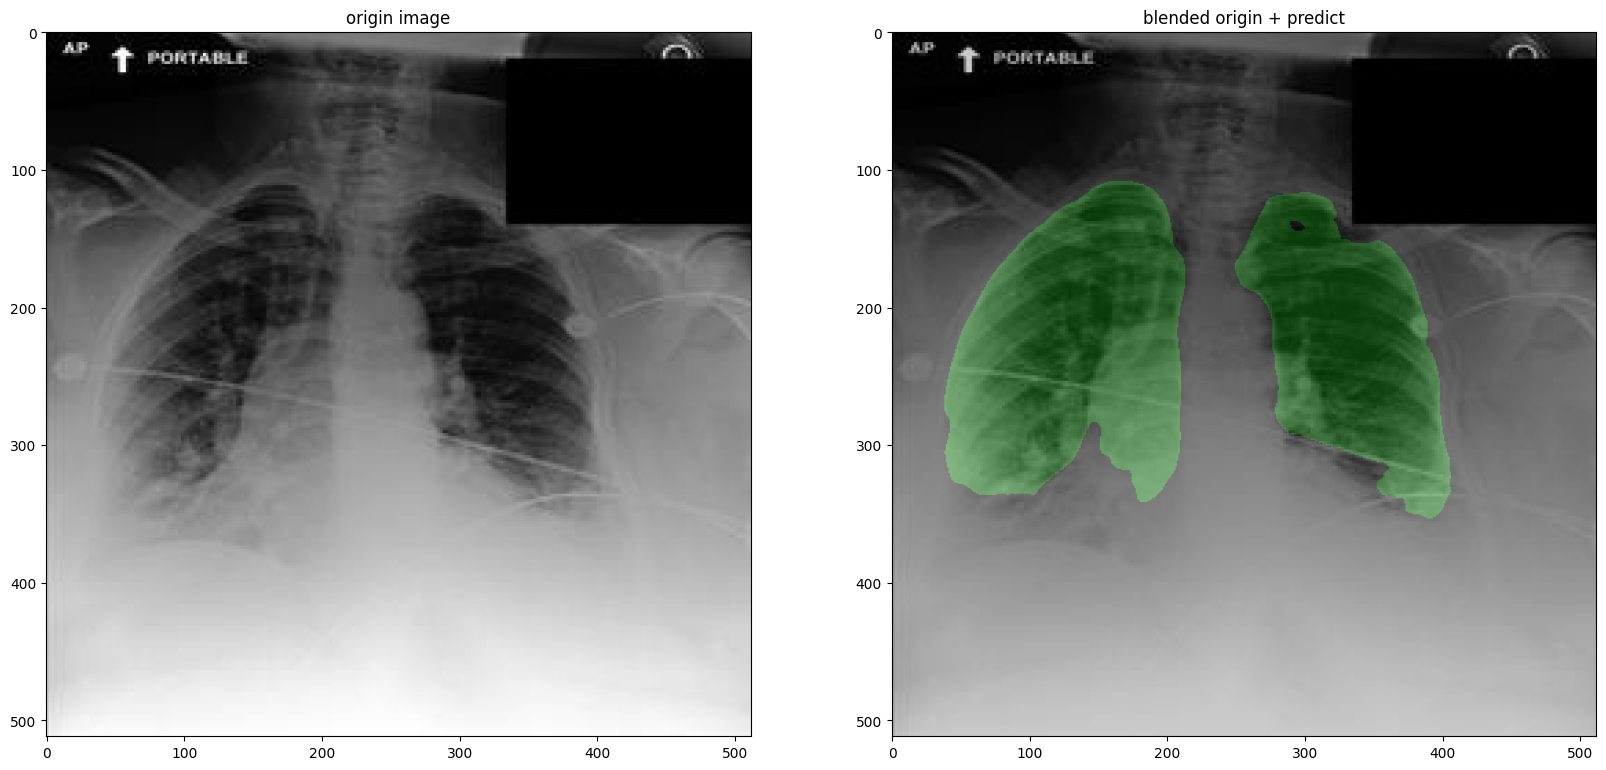

In [8]:
directory = "C:/Users/sonne/Downloads/images"

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.lower().endswith(".jpg"):
        origin_filename = os.path.join(directory, filename)
        origin = Image.open(origin_filename).convert("P")
        origin = torchvision.transforms.functional.resize(origin, (512, 512))
        origin = torchvision.transforms.functional.to_tensor(origin) - 0.5

        with torch.no_grad():
            origin = torch.stack([origin])
            origin = origin.to(device)
            out = unet(origin)
            softmax = torch.nn.functional.log_softmax(out, dim=1)
            out = torch.argmax(softmax, dim=1)
            
            origin = origin[0].to("cpu")
            out = out[0].to("cpu")

            plt.figure(figsize=(20, 10))

            pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

            plt.subplot(1, 2, 1)
            plt.title("origin image")
            plt.imshow(np.array(pil_origin))

            plt.subplot(1, 2, 2)
            plt.title("blended origin + predict")
            plt.imshow(np.array(blend(origin, out)))

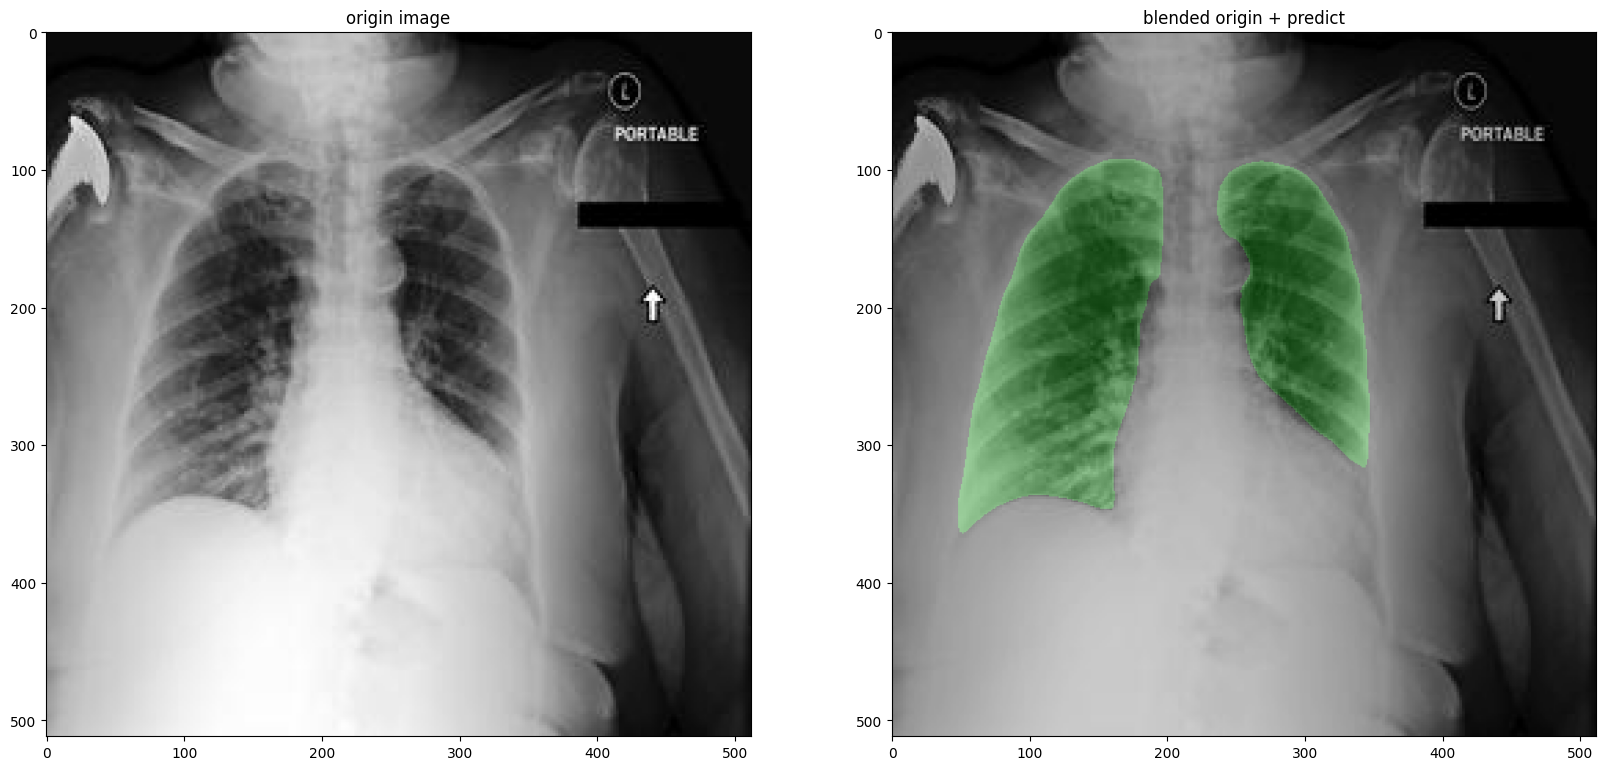